In [1]:
import rasterio
import numpy as np
import matplotlib as mpl
import subprocess
from matplotlib import pyplot
from rasterio.merge import merge
import geopandas as gpd
import os, math

In [2]:
geotiffPath = 'MERGED/20130301/'
NDWI2 = rasterio.open(geotiffPath + 'NDWI2.TIF')

In [3]:
from matplotlib import pyplot as plt
vn_reservoirs_path = 'vnreservoirs/VN_Reservoirs.shp'
df = gpd.read_file(vn_reservoirs_path)
plt.rcParams['figure.figsize'] = 5, 5
ho_tri_an = df[df.AREA_SKM == 277.4]

In [4]:
from rasterio.crs import CRS
from rasterio.warp import transform_geom
import rasterio.mask

from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from descartes import PolygonPatch

In [5]:
raw_file = NDWI2
trans = raw_file.transform

ho_tri_an_shape = ho_tri_an.geometry.values[0]
ho_tri_an_geom = mapping(ho_tri_an_shape)
ho_tri_an_shape = [transform_geom(df.crs, raw_file.crs,ho_tri_an_geom)]

/home/anhldt/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Find Rectangle that can bound!

In [6]:
inf = float("inf")
eps = 1000
x0, y0, x1, y1 = [inf, -inf, -inf, inf] #top-left, bottom-right
for x, y in ho_tri_an_shape[0]['coordinates'][0]:
    if x0 > x:
        x0 = x
    if x1 < x:
        x1 = x
    if y0 < y:
        y0 = y
    if y1 > y:
        y1 = y
new_coordinates = [{'type': 'Polygon', 'coordinates': [[(x0-eps, y0+eps),(x1+eps, y0+eps), 
                                                        (x1+eps, y1-eps), (x0-eps, y1-eps)]]}]
ndwi2, _ = rasterio.mask.mask(NDWI2, new_coordinates, crop=True)
ndwi2 = ndwi2.squeeze()

In [7]:
def insideMatrix(x, y, m, n):
    if x < 0 or x >= m or y < 0 or y >= n:
        return False
    return True

def check_expansion(val, type_of_map):
    if (type_of_map == 'NDVI'):
        if (val < 0):
            return True;
        return False;
    if (type_of_map == 'NDWI'):
        if (val > 0):
            return True;
        return False;
    if (type_of_map == 'NDWI2'):
        if (val > 0):
            return True;
        return False;  
    return null;

def count_pixel(obj, type_of_map, startingPoint):
    from queue import Queue
    dx = [0,1,0,-1]
    dy = [1,0,-1,0]

    visited = np.zeros((obj.shape[0], obj.shape[1])).astype('bool')
    final_obj= np.zeros((obj.shape[0], obj.shape[1]))

    u0, v0 = startingPoint[0], startingPoint[1]

    q = Queue()
    q.put((u0, v0))
    visited[u0, v0] = True
    countPixel = 0

    while not q.empty():
        u, v = q.get()
        final_obj[u, v] = 1
        countPixel += 1
        for k in range(4):
            _u, _v = u + dx[k], v + dy[k]
            if not insideMatrix(_u, _v, obj.shape[0], obj.shape[1]): 
                continue
            if visited[_u, _v]:
                continue
            if check_expansion(obj[_u, _v], type_of_map):
                visited[_u, _v] = True
                q.put((_u, _v))
    return countPixel, final_obj

## Segmentation based on BFS

Area = 297.8235


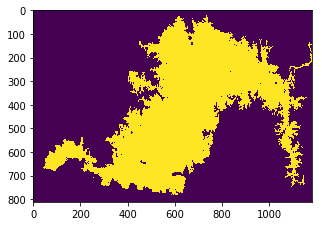

In [8]:
area, segment_array = count_pixel(ndwi2, 'NDWI2', [500, 600])
print("Area = {0}".format(area * 900 / 1000000))
plt.imshow(segment_array)

## Find Boundaries of Image

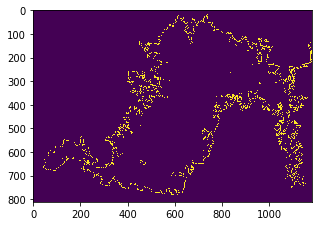

In [9]:
from skimage.segmentation import find_boundaries
boundaries_array = find_boundaries(segment_array.astype(np.uint8), mode='thick').astype(np.uint8)
plt.imshow(boundaries_array)

Get all boundaries found.

In [10]:
shapes = []
for _, __ in rasterio.features.shapes(boundaries_array,  transform=trans):
    shapes.append(_)

/home/anhldt/.local/lib/python3.5/site-packages/rasterio/features.py:102: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Depend on size of each shape-element, choose [-1] (difference least to original shapefile)

In [11]:
ndwi2_origin, _ = rasterio.mask.mask(NDWI2, ho_tri_an_shape, crop=True)
ndwi2_processed, _ = rasterio.mask.mask(NDWI2, [shapes[-1]], crop=True)

Comparision 

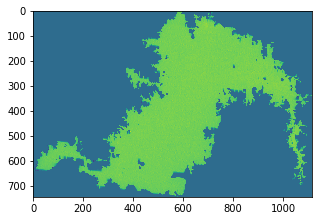

In [12]:
plt.imshow(ndwi2_origin.squeeze())

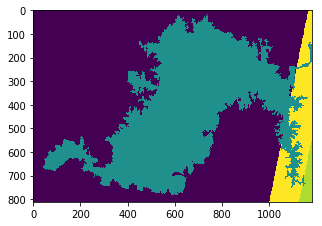

In [13]:
plt.imshow(ndwi2_processed.squeeze())

## Try to convert to original coordinates

In [14]:
new_shape_in_original_coordinates = [transform_geom( raw_file.crs, df.crs, shapes[-1])]

In [18]:
new_shape_in_original_coordinates

[{'coordinates': [[(106.7594246828197, 12.515690323700772),
    (106.75794704205359, 12.295504299581749),
    (107.0841382750569, 12.293213387318755),
    (107.08540965912947, 12.453441526693886),
    (107.08485791570622, 12.453445783924385),
    (107.08485575003152, 12.453174671929196),
    (107.0845798785296, 12.453176800074962),
    (107.08458204391823, 12.453447912117918),
    (107.08403030018961, 12.453452167661546),
    (107.08402164122882, 12.452367719072887),
    (107.08374577043239, 12.452369846231996),
    (107.08374360610543, 12.452098734022591),
    (107.08346773554415, 12.452100860852836),
    (107.083191864932, 12.452102987401968),
    (107.08318970122797, 12.451831875091294),
    (107.08291383085098, 12.451834001311585),
    (107.08290950416753, 12.451291776577392),
    (107.08263363431175, 12.451293902421131),
    (107.08263147133229, 12.451022789997618),
    (107.08235560171167, 12.451024915512544),
    (107.08234478900701, 12.449669353069483),
    (107.0820689207655, 

In [22]:
mapping(ho_tri_an.geometry.values[0])

{'coordinates': (((107.03711554633128, 11.116944444444655),
   (107.0370204671213, 11.117282986111277),
   (107.03677686903097, 11.117039659288409),
   (107.03711554633128, 11.116944444444655),
   (107.0368544514962, 11.116139865451544),
   (107.0362933349598, 11.115555826823055),
   (107.03586283365769, 11.115969509548819),
   (107.03541280110562, 11.117356228298789),
   (107.03502950032436, 11.117364095052253),
   (107.03465488009869, 11.116591796875198),
   (107.03311760796322, 11.118191731770978),
   (107.03225741916117, 11.117387152777937),
   (107.03171190049795, 11.115149739583487),
   (107.03061760796322, 11.114586046007148),
   (107.02926954481217, 11.115009765625203),
   (107.02864603678267, 11.11622016059043),
   (107.02891838921323, 11.116808268229377),
   (107.02947394476877, 11.117886827257152),
   (107.02896070692162, 11.118995768229368),
   (107.02671298556743, 11.119041612413369),
   (107.0261406114355, 11.11819715711826),
   (107.02542473686947, 11.117105577257092),
 